In [1]:
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, \
  BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test,y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1

11490434/11490434 [==============================] - 1s 0us/step


In [4]:
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [5]:
latent_dim = 100 #Dimensionality of the latent space

In [6]:
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(D, activation='tanh')(x)

  model = Model(i, x)
  return model

In [7]:
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)
  model = Model(i, x)
  return model

In [8]:
# Compile both models in preparation for training


# Build and compile the discriminator
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy'])

# Build and compile the combined model
generator = build_generator(latent_dim)

# Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

# Pass noise through generator to get an image
img = generator(z)

# Make sure only the generator is trained
discriminator.trainable = False

# The true output is fake, but we label them real!
fake_pred = discriminator(img)

# Create the combined model object
combined_model = Model(z, fake_pred)

# Compile the combined model
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [9]:
# Train the GAN


# Config
batch_size = 32
epochs = 7500
sample_period = 200 # every `sample_period` steps generate and save some data


# Create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store the losses
d_losses = []
g_losses = []

# Create a folder to store generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [10]:

def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

In [11]:
for epoch in range(epochs):
  idx= np.random.randint(0,x_train.shape[0],batch_size)#real images for training
  real_imgs=x_train[idx]
  noise= np.random.randn(batch_size,latent_dim)
  fake_imgs= generator.predict(noise)#fake images for testing and training
  d_loss_real, d_acc_real= discriminator.train_on_batch(real_imgs,ones)
  d_loss_fake,d_acc_fake=discriminator.train_on_batch(fake_imgs,zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc  = 0.5 * (d_acc_real + d_acc_fake) #just how loss is calculated in this scenario for gan training for discriminator
  #Train the generator
  noise= np.random.randn(batch_size, latent_dim)
  g_loss= combined_model.train_on_batch(noise, ones)
  noise= np.random.randn(batch_size, latent_dim)
  g_loss= combined_model.train_on_batch(noise, ones)
  d_losses.append(d_loss)
  g_losses.append(g_loss)
  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
      d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  if epoch % sample_period == 0:
    sample_images(epoch)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 15ms/step
epoch: 2601/7500, d_loss: 0.67,       d_acc: 0.70, g_loss: 0.75
1/1 [==============================] - 0s 17ms/step
epoch: 2701/7500, d_loss: 0.66,       d_acc: 0.59, g_loss: 0.76
1/1 [==============================] - 0s 18ms/step
epoch: 2801/7500, d_loss: 0.67,       d_acc: 0.59, g_loss: 0.77
1/1 [==============================] - 0s 16ms/step
epoch: 2901/7500, d_loss: 0.67,       d_acc: 0.62, g_loss: 0.77
1/1 [==============================] - 0s 16ms/step
epoch: 3001/7500, d_loss: 0.64,       d_acc: 0.72, g_loss: 0.78
1/1 [==============================] - 0s 16ms/step
epoch: 3101/7500, d_loss: 0.65,       d_acc: 0.62, g_loss: 0.72
1/1 [==============================] - 0s 16ms/step
epoch: 3201/7500, d_loss: 0.69,       d_acc: 0.66, g_loss: 0.75
1/1 [==============================] - 0s 15ms/step
epoch: 3301/7500, d_loss: 0.67,       d_acc: 0.62, g_loss: 0.75
1/1 [================

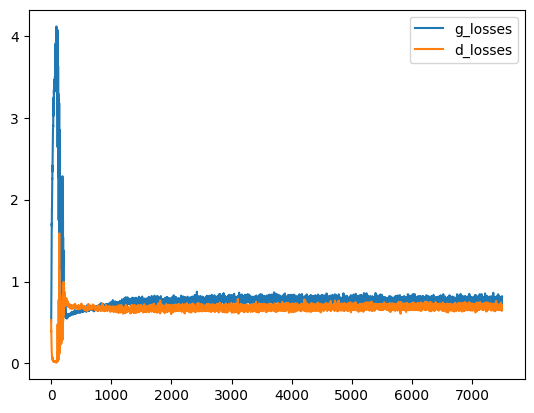

In [12]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

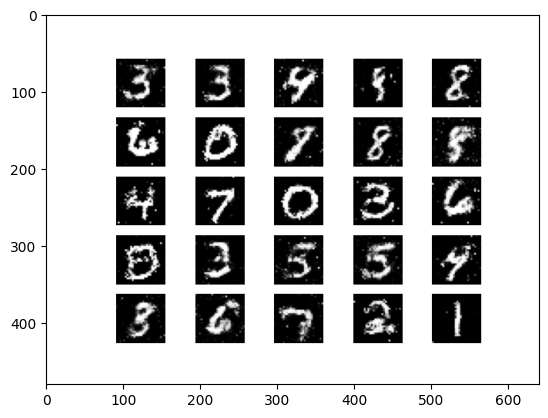

In [13]:
from skimage.io import imread
a = imread('gan_images/5000.png')
plt.imshow(a)